# 1\. Load dependency

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import arviz as az
import pymc as pm
import pickle
import seaborn as sns
from tqdm import tqdm
import time
from warnings import filterwarnings
import contextily as cx
import pickle
filterwarnings('ignore')
pd.set_option('display.max_row', 100)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#####
wintering_prefix = 'wintering_model_level_3_May15'
breeding_prefix = 'breeding_model_level_3_May15'
input_final_df_prefix='final_df_model_level_3_May15'
SAMPLE_SIZE=1000
SAMPLE_CHAINS=2
SAMPLE_CORES=2
TUNES=1000


# 2\. Load data

In [3]:
data=pd.read_csv('./8531.csv')
data.shape

(71963, 506)

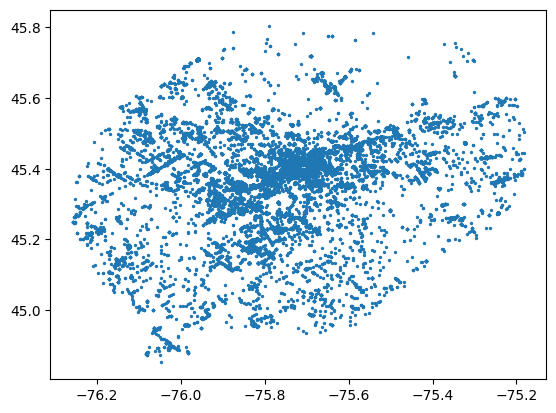

In [4]:
plt.scatter(data.longitude, data.latitude, s=2)
# ax =plt.gca()
# cx.add_basemap(ax, crs='EPSG:4326')
plt.show()

In [5]:
data.latitude.mean(), data.longitude.mean()

(45.35012631018301, -75.77214829329655)

In [6]:
data[data.urban_areas>0].shape, data[data.urban_areas==0].shape


((61639, 506), (10324, 506))

In [7]:
pm.__version__

'5.3.1'

# 3\. Load taxonomy data and filter species list

In [8]:
#### read taxonomy data
ebird = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/ebird_taxonomy/eBird_Taxonomy_v2021.csv')
avonet_raw = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/AVONET/AVONET_Raw_Data.csv')
migration = pd.read_csv('/Users/chenyangkang/Desktop/Bird_Functional_Traits/AVONET/AVONET1_BirdLife.csv')
taxon = ebird[['PRIMARY_COM_NAME','SCI_NAME','ORDER1','FAMILY']].drop_duplicates().rename(columns={'SCI_NAME':'Species2_eBird'}).merge(
    avonet_raw[['Species1_BirdLife','Species2_eBird']].drop_duplicates(),
    on='Species2_eBird', how='left'
    ).merge(
    migration[['Species1','Migration']].rename(columns={'Species1':'Species1_BirdLife'}),
    on='Species1_BirdLife', how='left'
    )
taxon = taxon[taxon['Migration']>1]


In [9]:
sp_list = list(data.columns)[list(data.columns).index('entropy')+1:]
sp_list = set(taxon.PRIMARY_COM_NAME.dropna().unique()) & set(sp_list)
sp_list = list(sp_list)
len(sp_list)

278

In [10]:
data[sp_list] = np.where(data[sp_list].fillna(0)>0,1,0)


In [11]:
### sorted sp list
sp_list = [i[0] for i in sorted(data[sp_list].sum().items(), key=lambda x:-x[1])]


# 4\. Filter input data by quality, demography, and migration type

In [12]:
def classify_mig_type(sub):
    
    spring_range = list(np.arange(60,152))
    summer_range = list(np.arange(152,245))
    fall_range = list(np.arange(245,337))
    winter_range = list(np.arange(1,60)) + list(np.arange(337,366))
    
    spring_occ = sub[sub.DOY.isin(spring_range)]['occ'].mean()
    summer_occ = sub[sub.DOY.isin(summer_range)]['occ'].mean()
    fall_occ = sub[sub.DOY.isin(fall_range)]['occ'].mean()
    winter_occ = sub[sub.DOY.isin(winter_range)]['occ'].mean()
    
    
    ###
    flag_list = []
    
    ### passgenger?
    if (spring_occ > winter_occ*3) & (fall_occ > winter_occ*3) & \
            (spring_occ > summer_occ*3) & (fall_occ > summer_occ*3):
        flag_list.append('passenger')
    
    if (winter_occ > summer_occ*3) & (winter_occ > spring_occ) & (winter_occ > fall_occ):
        flag_list.append('wintering')
    
    if (summer_occ > winter_occ*3) & (summer_occ > spring_occ) & (summer_occ > fall_occ):
        flag_list.append('breeding')
    
    return flag_list
        

In [13]:
## calculate cropland
data['cropland'] = data[['cropland_rainfed','cropland_irrigated_post_flooding','mosaic_cropland']].fillna(0).sum(axis=1).values



In [14]:
def assign_spatial_temporal_grid(sub):
    '''
        Spatial-temporal-urban-cropland subsampling. Five dimention. Booooom!
    '''
    lon_array = np.arange(sub.longitude.min(), sub.longitude.max(), 0.05)
    lat_array =  np.arange(sub.latitude.min(), sub.latitude.max(), 0.05)
    doy_array =  np.arange(sub.DOY.min(), sub.DOY.max(), 1)
    sub['lon_lat_doy_urban_crop_grid'] = [str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)+'_'+str(m) for i,j,k,l,m in zip(np.digitize(sub.longitude, lon_array),
                            np.digitize(sub.latitude, lat_array),
                            np.digitize(sub.DOY, doy_array),
                            np.where(sub.cropland>0,1,0),
                               np.where(sub.urban_areas>0,1,0)
                               )]
    
    return sub


def down_sample(new_sub, samples_each_class=500):
    '''
        If the sample size is still too large -- subsample
    '''
    
    spring_range = list(np.arange(60,152)) + list(range(40,60)) + list(range(152,172))
    summer_range = list(np.arange(152,245)) 
    fall_range = list(np.arange(245,337)) + list(range(225,245)) + list(range(337,357))
    winter_range = list(np.arange(1,60)) + list(np.arange(337,366))
    
    occ_new_sub = new_sub[new_sub.occ==0]
    
    def get_sample_by_seasons(df_, samples_each_class):
        spring_df = df_[df_.DOY.isin(spring_range)]
        fall_df = df_[df_.DOY.isin(fall_range)]
        non_migrating_df = df_[(~df_.DOY.isin(spring_df)) & (~df_.DOY.isin(fall_range))]
        
        sample_size = samples_each_class//3
        
        def get_sample(df,sample_size):
            if len(df)>sample_size:
                df = df.sample(sample_size, replace=False) ### if data is abundant, first sample expert's checklist
            else: #.iloc[:samples_each_class,:].sort_values(by='obsvr_species_count', ascending=False)
                pass #df = df.sample(sample_size, replace=True)
            return df
        
        new_df_ = pd.concat(
            [get_sample(spring_df, sample_size),
            get_sample(fall_df, sample_size),
            get_sample(non_migrating_df, sample_size)],
            axis=0
        ).reset_index(drop=True)
        
        return new_df_
    
    occ_new_sub = get_sample_by_seasons(new_sub[new_sub.occ==0], samples_each_class)
    non_occ_new_sub = get_sample_by_seasons(new_sub[new_sub.occ>0], samples_each_class)
    return pd.concat([occ_new_sub, non_occ_new_sub], axis=0).reset_index(drop=True)




In [15]:
def get_ml_score(X, y):
    ## can i use DOY, urban, cropland, duration to predict occ?
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_auc_score, precision_score, accuracy_score,make_scorer
    
    model = RandomForestClassifier(random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score))
    return np.nanmean(scores)

In [16]:
#### pre-process data: filter species, subsampling
final_list = []
for sp in tqdm(sp_list):
    sp_order = taxon[taxon['PRIMARY_COM_NAME']==sp]['ORDER1'].values[0]
    sub = data[['DOY','year','obsvr_species_count','longitude','latitude','urban_areas','cropland','duration_minutes',sp]]
    sub = sub[(sub.obsvr_species_count>sorted(sub.obsvr_species_count)[int(len(sub)*0.05)]) &\
        (sub.obsvr_species_count<sorted(sub.obsvr_species_count)[int(len(sub)*0.95)])] #### remove outlier birder with extreme bird species count
    sub['Order'] = sp_order
    sub[sp] = sub[sp].fillna(0)
    sub=sub.dropna().rename(columns={sp:'occ'})
    sub['occ'] = np.where(sub['occ']>0,1,0)
    sub['sp'] = sp
    
    ### filtering
    ### only take summer breeding indiv
    flag_list = classify_mig_type(sub)
    if len(flag_list)>1 or len(flag_list)==0:
        continue
    else:
        flag=flag_list[0]
        
    #### filtering for each year
    sp_df_list = []
    for year in sorted(sub.year.unique()):
        ### filtering
        subsub=sub[sub.year==year]

        ### resample    
        ### subsample
        subsub = assign_spatial_temporal_grid(subsub)
        subsub = subsub.sample(frac=1, replace=False).groupby('lon_lat_doy_urban_crop_grid').first()
        
        if subsub[subsub.occ>0].shape[0]<100: ### after subsampling, if less than 100 observations, skip
            continue
        if len(subsub[(subsub.urban_areas>0) & (subsub.occ>0)])<30:
            continue
        if len(subsub[(subsub.cropland>0) & (subsub.occ>0)])<30:
            continue
        if len(subsub[(subsub.urban_areas==0) & (subsub.cropland==0) & (subsub.occ>0)])<30:
            continue
            
        if len(subsub)>1000: #.sort_values(by='obsvr_species_count',ascending=False)
            subsub = down_sample(sub, samples_each_class=500) 
            
        subsub['migration_type'] = flag
        
        #### ml score
        x_names = ['DOY','urban_areas','cropland','duration_minutes']
        ml_score = get_ml_score(subsub[x_names], subsub['occ'])
        if ml_score>0.6:
            sp_df_list.append(subsub)
        else:
            pass
    
    if len(sp_df_list)==0:
        continue
    
    print(flag,end='..')
    print(f'{len(sp_df_list)} years samples',end='..')
    final_list.append(pd.concat(sp_df_list, axis=0).reset_index(drop=True))
    
    
print('total species: ',len(final_list))
final_df = pd.concat(final_list, axis=0).reset_index(drop=True)



  1%|          | 2/278 [00:04<09:36,  2.09s/it]

breeding..7 years samples..

  3%|▎         | 7/278 [00:08<04:04,  1.11it/s]

breeding..1 years samples..breeding..5 years samples..

  3%|▎         | 9/278 [00:14<07:08,  1.59s/it]

breeding..5 years samples..

  4%|▎         | 10/278 [00:17<08:34,  1.92s/it]

wintering..5 years samples..

  5%|▍         | 13/278 [00:20<06:17,  1.42s/it]

breeding..4 years samples..

  5%|▌         | 15/278 [00:22<06:01,  1.37s/it]

breeding..4 years samples..

  6%|▋         | 18/278 [00:25<05:01,  1.16s/it]

breeding..4 years samples..

  7%|▋         | 19/278 [00:27<05:50,  1.35s/it]

breeding..4 years samples..

  7%|▋         | 20/278 [00:30<06:42,  1.56s/it]

breeding..4 years samples..

  8%|▊         | 21/278 [00:32<07:23,  1.73s/it]

breeding..4 years samples..

  8%|▊         | 22/278 [00:34<07:58,  1.87s/it]

breeding..4 years samples..

  9%|▉         | 26/278 [00:37<04:51,  1.16s/it]

breeding..4 years samples..

 10%|▉         | 27/278 [00:39<05:21,  1.28s/it]

wintering..3 years samples..

 10%|█         | 28/278 [00:42<06:42,  1.61s/it]

wintering..5 years samples..

 10%|█         | 29/278 [00:44<07:25,  1.79s/it]

breeding..4 years samples..

 11%|█         | 31/278 [00:47<06:37,  1.61s/it]

breeding..1 years samples..

 12%|█▏        | 32/278 [00:49<07:18,  1.78s/it]

breeding..4 years samples..

 12%|█▏        | 34/278 [00:52<06:20,  1.56s/it]

breeding..4 years samples..

 13%|█▎        | 35/278 [00:54<07:11,  1.78s/it]

breeding..2 years samples..

 14%|█▎        | 38/278 [00:57<05:19,  1.33s/it]

breeding..4 years samples..

 14%|█▍        | 40/278 [00:59<05:19,  1.34s/it]

breeding..4 years samples..

 15%|█▍        | 41/278 [01:02<06:02,  1.53s/it]

breeding..4 years samples..

 15%|█▌        | 42/278 [01:04<06:44,  1.71s/it]

breeding..4 years samples..

 16%|█▌        | 44/278 [01:06<05:34,  1.43s/it]

breeding..3 years samples..

 17%|█▋        | 47/278 [01:08<04:09,  1.08s/it]

breeding..3 years samples..

 17%|█▋        | 48/278 [01:10<04:42,  1.23s/it]

breeding..3 years samples..

 19%|█▉        | 53/278 [01:11<02:16,  1.65it/s]

breeding..2 years samples..

 21%|██        | 58/278 [01:13<01:29,  2.46it/s]

breeding..1 years samples..

 21%|██        | 59/278 [01:13<01:43,  2.12it/s]

breeding..1 years samples..

 22%|██▏       | 61/278 [01:14<01:37,  2.22it/s]

breeding..1 years samples..

 24%|██▎       | 66/278 [01:15<00:51,  4.13it/s]

breeding..1 years samples..

 28%|██▊       | 79/278 [01:17<00:31,  6.22it/s]

breeding..1 years samples..

100%|██████████| 278/278 [01:40<00:00,  2.76it/s]

total species:  33


In [17]:
def reindexing(df):
    df['record_index'] = list(range(len(df)))
    df['year_index'] = pd.factorize(df.year)[0]
    df['order_index'] = pd.factorize(df.Order)[0]
    df['sp_index'] = pd.factorize(df.sp)[0]
    # df['duration_minutes'] = (df['duration_minutes'] - df['duration_minutes'].mean())/df['duration_minutes'].std()
    # df['urban_areas'] = (df['urban_areas'] - df['urban_areas'].mean())/df['urban_areas'].std()
    # df['cropland'] = (df['cropland'] - df['cropland'].mean())/df['cropland'].std()
    return df

In [18]:
### save the final input file
final_df.to_csv(f'{input_final_df_prefix}.csv',index=False)

In [19]:
### split by patter
passenger_df = reindexing(
    final_df[final_df.migration_type=='passenger']
    )
breeding_df = reindexing(
    final_df[final_df.migration_type=='breeding']
)
wintering_df = reindexing(
    final_df[final_df.migration_type=='wintering']
)
print(passenger_df.shape,breeding_df.shape, wintering_df.shape)


(0, 16) (96612, 16) (12948, 16)


In [20]:
### save the final input file
wintering_df.to_csv(f'{wintering_prefix}.csv',index=False)
breeding_df.to_csv(f'{breeding_prefix}.csv',index=False)


In [21]:
wintering_df.sp.unique()

array(['Dark-eyed Junco', 'American Tree Sparrow', 'Common Goldeneye'],
      dtype=object)

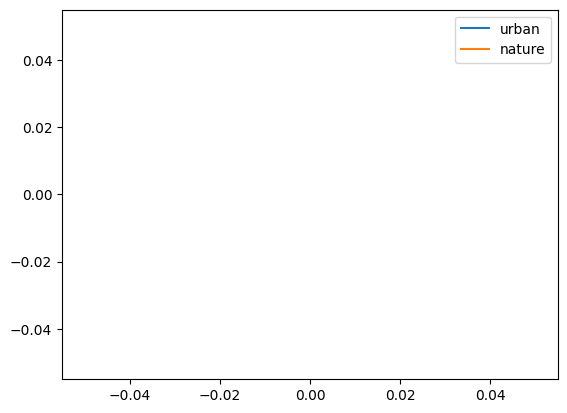

In [22]:
# plt.plot(passenger_df[['DOY','occ']].groupby('DOY').mean().rolling(10).mean())
plt.plot(passenger_df[passenger_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(passenger_df[passenger_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()



In [23]:
passenger_df

Empty DataFrame
Columns: [DOY, year, obsvr_species_count, longitude, latitude, urban_areas, cropland, duration_minutes, occ, Order, sp, migration_type, record_index, year_index, order_index, sp_index]
Index: []

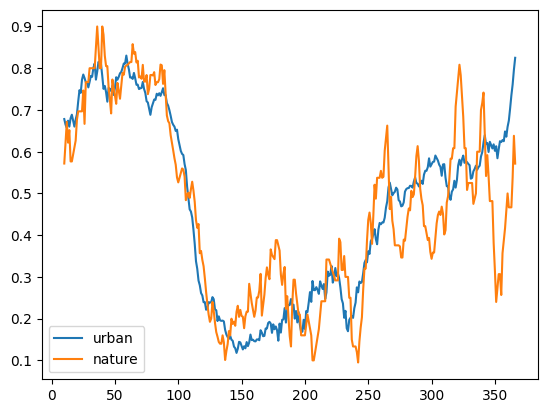

In [24]:

plt.plot(wintering_df[wintering_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(wintering_df[wintering_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()


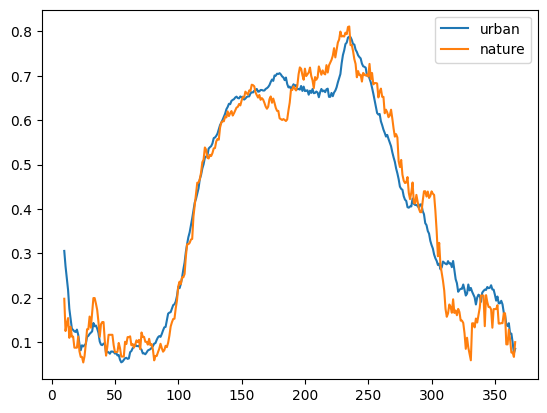

In [25]:

plt.plot(breeding_df[breeding_df.urban_areas>0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(), label='urban')
plt.plot(breeding_df[breeding_df.urban_areas==0][['DOY','occ']].groupby('DOY').mean().rolling(10).mean(),label='nature')
plt.legend()
plt.show()


In [26]:
breeding_df

DOY  year  obsvr_species_count  longitude   latitude  urban_areas   
0        96  2014                 1054 -75.802913  45.373861     0.266304  \
1       114  2018                  806 -75.803733  45.364049     0.432361   
2       116  2015                  398 -75.643783  45.306749     0.024631   
3       149  2016                  343 -75.832396  45.303558     0.322289   
4        90  2018                  405 -75.766331  45.350099     0.860158   
...     ...   ...                  ...        ...        ...          ...   
109555  200  2017                  388 -75.771432  45.350403     0.835509   
109556  206  2016                  527 -75.803611  45.326667     0.623656   
109557  137  2015                 1314 -75.773928  45.222919     0.000000   
109558    1  2018                  230 -75.733776  45.405446     0.674797   
109559  140  2016                  127 -75.506243  45.514345     0.208333   

        cropland  duration_minutes  occ          Order            sp   
0       0.005435              32.0    0  Passeriformes  Song Sparrow  \
1       0.000000              17.0    0  Passeriformes  Song Sparrow   
2       0.226601              60.0    0  Passeriformes  Song Sparrow   
3       0.009036              57.0    0  Passeriformes  Song Sparrow   
4       0.002639              15.0    0  Passeriformes  Song Sparrow   
...          ...               ...  ...            ...           ...   
109555  0.005222              20.0    1  Passeriformes  Pine Warbler   
109556  0.028674              20.0    1  Passeriformes  Pine Warbler   
109557  0.439024              15.0    1  Passeriformes  Pine Warbler   
109558  0.008130              55.0    1  Passeriformes  Pine Warbler   
109559  0.059524              60.0    1  Passeriformes  Pine Warbler   

       migration_type  record_index  year_index  order_index  sp_index  
0            breeding             0           0            0         0  
1            breeding             1           1            0         0  
2            breeding             2           2            0         0  
3            breeding             3           3            0         0  
4            breeding             4           1            0         0  
...               ...           ...         ...          ...       ...  
109555       breeding         96607           6            0        29  
109556       breeding         96608           3            0        29  
109557       breeding         96609           2            0        29  
109558       breeding         96610           1            0        29  
109559       breeding         96611           3            0        29  

[96612 rows x 16 columns]

In [27]:
wintering_df

DOY  year  obsvr_species_count  longitude   latitude  urban_areas   
17928   97  2008                  227 -75.799720  45.377780     0.215084  \
17929   48  2016                 1336 -75.828270  45.175072     0.176471   
17930   84  2018                  130 -75.799720  45.377780     0.308123   
17931  107  2013                 1374 -75.793224  45.366491     0.420635   
17932  165  2015                  780 -75.584725  45.484544     0.185455   
...    ...   ...                  ...        ...        ...          ...   
62743   62  2017                  546 -75.849695  45.281077     0.441406   
62744   57  2017                  645 -75.926170  45.369996     0.235507   
62745   71  2013                 1032 -75.609305  45.455420     0.378549   
62746   76  2018                  597 -75.670137  45.426313     0.753846   
62747   91  2018                  337 -75.797210  45.318931     0.509881   

       cropland  duration_minutes  occ          Order                sp   
17928  0.013966              80.0    0  Passeriformes   Dark-eyed Junco  \
17929  0.026144              60.0    0  Passeriformes   Dark-eyed Junco   
17930  0.014006             120.0    0  Passeriformes   Dark-eyed Junco   
17931  0.002646              25.0    0  Passeriformes   Dark-eyed Junco   
17932  0.021818             180.0    0  Passeriformes   Dark-eyed Junco   
...         ...               ...  ...            ...               ...   
62743  0.042969              13.0    1   Anseriformes  Common Goldeneye   
62744  0.000000             185.0    1   Anseriformes  Common Goldeneye   
62745  0.012618              24.0    1   Anseriformes  Common Goldeneye   
62746  0.000000              90.0    1   Anseriformes  Common Goldeneye   
62747  0.047431              30.0    1   Anseriformes  Common Goldeneye   

      migration_type  record_index  year_index  order_index  sp_index  
17928      wintering             0           0            0         0  
17929      wintering             1           1            0         0  
17930      wintering             2           2            0         0  
17931      wintering             3           3            0         0  
17932      wintering             4           4            0         0  
...              ...           ...         ...          ...       ...  
62743      wintering         12943           6            1         2  
62744      wintering         12944           6            1         2  
62745      wintering         12945           3            1         2  
62746      wintering         12946           2            1         2  
62747      wintering         12947           2            1         2  

[12948 rows x 16 columns]

# 5\. Spring departure model

## 5\.0 Train test split

In [28]:
from sklearn.model_selection import train_test_split
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for sp in wintering_df.sp.unique():
    sub = wintering_df[wintering_df.sp==sp]
    
    X_train, X_test, y_train, y_test = train_test_split(sub[[i for i in sub.columns if not i=='occ']],
                                                        sub['occ'],test_size=0.2)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    
X_train = pd.concat(X_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

#### normalize
X_train_duration_minutes_std= X_train.duration_minutes.std()
X_train_duration_minutes_mean= X_train.duration_minutes.mean()
X_train_cropland_std= X_train.cropland.std()
X_train_cropland_mean= X_train.cropland.mean()
X_train_urban_areas_std= X_train.urban_areas.std()
X_train_urban_areas_mean= X_train.urban_areas.mean()

X_train['duration_minutes'] = (X_train['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_test['duration_minutes'] = (X_test['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_train['cropland'] = (X_train['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_test['cropland'] = (X_test['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_train['urban_areas'] = (X_train['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std
X_test['urban_areas'] = (X_test['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std



## 5\.1 Define model

In [29]:
### passenger model
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))

### running

wintering_model = pm.Model()

with wintering_model:
    wintering_model.add_coord("record_index", sorted(wintering_df['record_index'].unique()))
    wintering_model.add_coord("sp_index", sorted(wintering_df['sp_index'].unique()))
    wintering_model.add_coord("year_index", sorted(wintering_df['year_index'].unique()))
    wintering_model.add_coord("order_index", sorted(wintering_df['order_index'].unique()))
    
    
    DOY_obs = pm.Data('DOY_obs',X_train.DOY.values)
    occ_obs = pm.Data('occ_obs',y_train.values)
    urban_areas_obs = pm.Data('urban_areas_obs',X_train.urban_areas.values)
    cropland_obs = pm.Data('cropland_obs',X_train.cropland.values)
    duration_obs = pm.Data('duration_obs',X_train.duration_minutes.values)
    
    sp_index_obs = pm.Data('sp_index_obs', X_train.sp_index.values)
    year_index_obs = pm.Data('year_index_obs', X_train.year_index.values)
    order_to_sp_obs = pm.Data('order_to_sp_obs', X_train[['sp_index','order_index']].drop_duplicates().sort_values(by='sp_index')['order_index'].values)
    
    ### prior
    ## spring departure
    spring_departure_dist_mu_overall = pm.TruncatedNormal('spring_departure_dist_mu_overall', mu=106, sigma=20, lower=0, upper=175)
    spring_departure_dist_mu = pm.TruncatedNormal('spring_departure_dist_mu', mu=spring_departure_dist_mu_overall, sigma=20, lower=0, upper=175, dims=('sp_index','year_index'))
    spring_departure_dist_sigma = pm.Gamma('spring_departure_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    ## fall arrival
    fall_arrival_dist_mu_overall = pm.TruncatedNormal('fall_arrival_dist_mu_overall', mu=291, sigma=20, lower=175, upper=366)
    fall_arrival_dist_mu = pm.TruncatedNormal('fall_arrival_dist_mu', mu=fall_arrival_dist_mu_overall, sigma=20, lower=175, upper=366, dims=('sp_index','year_index'))
    fall_arrival_dist_sigma = pm.Gamma('fall_arrival_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    # #### urban effect   
    spring_departure_urban_effect_overall = pm.TruncatedNormal('spring_departure_urban_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    spring_departure_urban_effect_order_level = pm.TruncatedNormal('spring_departure_urban_effect_order_level', mu=spring_departure_urban_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    spring_departure_urban_effect = pm.TruncatedNormal('spring_departure_urban_effect', mu=spring_departure_urban_effect_order_level[order_to_sp_obs], 
                                              sigma=20, upper=50, lower=-50, dims=('sp_index'))
    fall_arrival_urban_effect_overall = pm.TruncatedNormal('fall_arrival_urban_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    fall_arrival_urban_effect_order_level = pm.TruncatedNormal('fall_arrival_urban_effect_order_level', mu=fall_arrival_urban_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    fall_arrival_urban_effect = pm.TruncatedNormal('fall_arrival_urban_effect', mu=fall_arrival_urban_effect_order_level[order_to_sp_obs],
                                          sigma=20, upper=50, lower=-50, dims=('sp_index'))
    
    #### cropland effect   
    spring_departure_cropland_effect_overall = pm.TruncatedNormal('spring_departure_cropland_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    spring_departure_cropland_effect_order_level = pm.TruncatedNormal('spring_departure_cropland_effect_order_level', mu=spring_departure_cropland_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    spring_departure_cropland_effect = pm.TruncatedNormal('spring_departure_cropland_effect', mu=spring_departure_cropland_effect_order_level[order_to_sp_obs], 
                                                 sigma=20, upper=50, lower=-50, dims=('sp_index'))
    fall_arrival_cropland_effect_overall = pm.TruncatedNormal('fall_arrival_cropland_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    fall_arrival_cropland_effect_order_level = pm.TruncatedNormal('fall_arrival_cropland_effect_order_level', mu=fall_arrival_cropland_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    fall_arrival_cropland_effect = pm.TruncatedNormal('fall_arrival_cropland_effect', mu=fall_arrival_cropland_effect_order_level[order_to_sp_obs], 
                                             sigma=20, upper=50, lower=-50, dims=('sp_index'))
    
    ##### intercept
    beta = pm.Normal('beta', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    ### duration effect
    duration_effect_slope = pm.TruncatedNormal('duration_effect_slope', mu=0, sigma=10, lower=0, dims=('sp_index'))
    
    #### city effect modification on timing
    #####
    
    modified_spring_departure_dist = spring_departure_dist_mu[sp_index_obs, year_index_obs] + \
                                        (spring_departure_urban_effect[sp_index_obs] * urban_areas_obs + \
                                            spring_departure_cropland_effect[sp_index_obs] * cropland_obs)
    modified_fall_arrival_dist = fall_arrival_dist_mu[sp_index_obs, year_index_obs] + \
                                        (fall_arrival_urban_effect[sp_index_obs] * urban_areas_obs + \
                                            fall_arrival_cropland_effect[sp_index_obs] * cropland_obs)

    ### scaling factor
    w = pm.Dirichlet('w', a=np.ones([len(X_train.sp_index.unique()),
                                    len(X_train.year_index.unique()),
                                    2]))
    soft_diff_constraint_on_w = pm.Potential("soft_diff_constraint_on_w", -((pm.math.log(w[...,0]) - pm.math.log(w[...,1]))**2))
    
    ### variables times scalers
    spring_departure_effect_on_obs_prob = -(cumulative_normal(x=DOY_obs, 
                              mu=modified_spring_departure_dist, 
                              sigma=spring_departure_dist_sigma[sp_index_obs, year_index_obs])) * w[sp_index_obs, year_index_obs, 0]
 
        
    fall_arrival_effect_on_obs_prob =  (cumulative_normal(x=DOY_obs, 
                                                         mu=modified_fall_arrival_dist, 
                                                         sigma=fall_arrival_dist_sigma[sp_index_obs, year_index_obs]))* w[sp_index_obs, year_index_obs, 1]

    #### Effect of land use on detectability
    urban_effect_on_detectability_overall = pm.Normal('urban_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    cropland_effect_on_detectability_overall = pm.Normal('cropland_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    #### alpha
    alpha = pm.HalfNormal('alpha', sigma=10, dims=('sp_index','year_index'))
    
    #### linear term 
    y0 = beta[sp_index_obs, year_index_obs] + \
            duration_effect_slope[sp_index_obs] * duration_obs + \
            urban_effect_on_detectability_overall[sp_index_obs, year_index_obs] * urban_areas_obs + \
            cropland_effect_on_detectability_overall[sp_index_obs, year_index_obs] * cropland_obs + \
            alpha[sp_index_obs, year_index_obs] * (spring_departure_effect_on_obs_prob + fall_arrival_effect_on_obs_prob)
            
    p_ = pm.math.sigmoid(y0)
    
    y_ = pm.Bernoulli("y_", p_, observed=occ_obs)
    

    

    

## 5\.2 Sample chains

In [30]:
import pymc.sampling.jax as pmjax
import jax
import tensorflow_probability.substrates.jax as tfp
jax.scipy.special.erfcx = tfp.math.erfcx
from fastprogress.fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

with wintering_model:
    idata = pmjax.sample_numpyro_nuts(SAMPLE_SIZE,chains=SAMPLE_CHAINS,cores=SAMPLE_CORES, tune=TUNES, progressbar=True)

    #  target_accept=0.99,
    #                   chains=2, cores=2, tune=3000, progressbar=True,
    #                     # trace = ['y_']
                      

Compiling...
Compilation time =  0:00:13.274102
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:05:47.703137
Transforming variables...
Transformation time =  0:00:00.842781


In [31]:
with wintering_model:
    post_idata = pm.sample_posterior_predictive(idata)

<Axes: xlabel='DOY'>

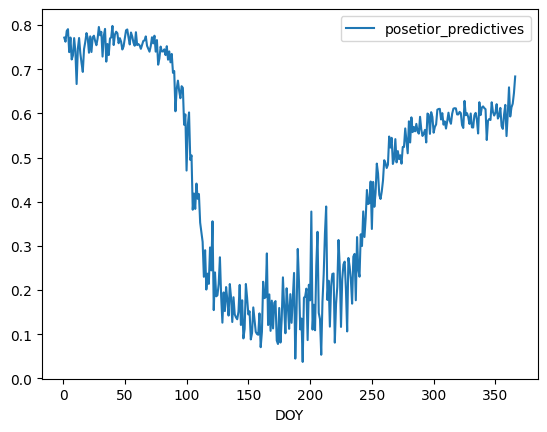

In [32]:
pd.DataFrame({
    'DOY':X_train.DOY.values,
    'posetior_predictives':np.concatenate(post_idata.posterior_predictive['y_'], axis=0).mean(axis=0)
}).groupby('DOY').mean().plot()


## 5\.3 Predict on test data

In [33]:
def pm_predict_winter_model(X_test):
    ### passenger model
    import math
    from scipy.special import expit
    def math_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return 0.5 + 0.5 * math.erf((x-mu)/(sigma*s))

    new_DOY_obs = X_test['DOY'].values
    new_sp_index_obs = X_test['sp_index'].values
    new_year_index_obs = X_test['year_index'].values
    new_urban_areas_obs = X_test['urban_areas'].values
    new_cropland_obs = X_test['cropland'].values
    new_duration_obs = X_test['duration_minutes'].values

    new_beta = np.concatenate(idata.posterior['beta'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_duration_effect_on_obs_prob = np.concatenate(idata.posterior['duration_effect_slope'].values, axis=0).mean(axis=0)[new_sp_index_obs]

    new_modified_spring_departure_dist = np.concatenate(idata.posterior['spring_departure_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                            np.concatenate(idata.posterior['spring_departure_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                                np.concatenate(idata.posterior['spring_departure_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                                
    new_spring_departure_effect_on_obs_prob =  (
        np.array([-math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
        new_DOY_obs,
        new_modified_spring_departure_dist, 
        np.concatenate(idata.posterior['spring_departure_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    )])) * np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 0]

    new_modified_fall_arrival_dist = np.concatenate(idata.posterior['fall_arrival_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                        np.concatenate(idata.posterior['fall_arrival_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                            np.concatenate(idata.posterior['fall_arrival_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                            
    new_fall_arrival_effect_on_obs_prob = (np.array([
        math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
            new_DOY_obs,
            new_modified_fall_arrival_dist,
            np.concatenate(idata.posterior['fall_arrival_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
        )
    ]))* np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 1]

    new_alpha = np.concatenate(idata.posterior['alpha'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_urban_effect_on_detectability_overall = np.concatenate(idata.posterior['urban_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_cropland_effect_on_detectability_overall = np.concatenate(idata.posterior['cropland_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_y0 = new_beta + \
            new_duration_effect_on_obs_prob * new_duration_obs + \
            new_urban_effect_on_detectability_overall * new_urban_areas_obs + \
            new_cropland_effect_on_detectability_overall * new_cropland_obs + \
            new_alpha * (new_spring_departure_effect_on_obs_prob + new_fall_arrival_effect_on_obs_prob)
            
    new_p_ = expit(new_y0)
    y_pred = np.where(new_p_>0.5,1,0)
    return y_pred





In [34]:
y_pred = pm_predict_winter_model(X_test)

In [35]:
post_bi = np.where(
    np.concatenate(post_idata.posterior_predictive['y_'].values, axis=0).mean(axis=0)>0.5,
    1,0
)


In [36]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print(
    roc_auc_score(y_train, post_bi), precision_score(y_train, post_bi), recall_score(y_train, post_bi), f1_score(y_train, post_bi)
)

print(
    roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
)


0.7508637777078933 0.7016342412451362 0.871447902571042 0.7773754095533714
0.7403396802244976 0.6937269372693727 0.8670253651037664 0.7707550392893748


## 5\.4 Evaluate and save data

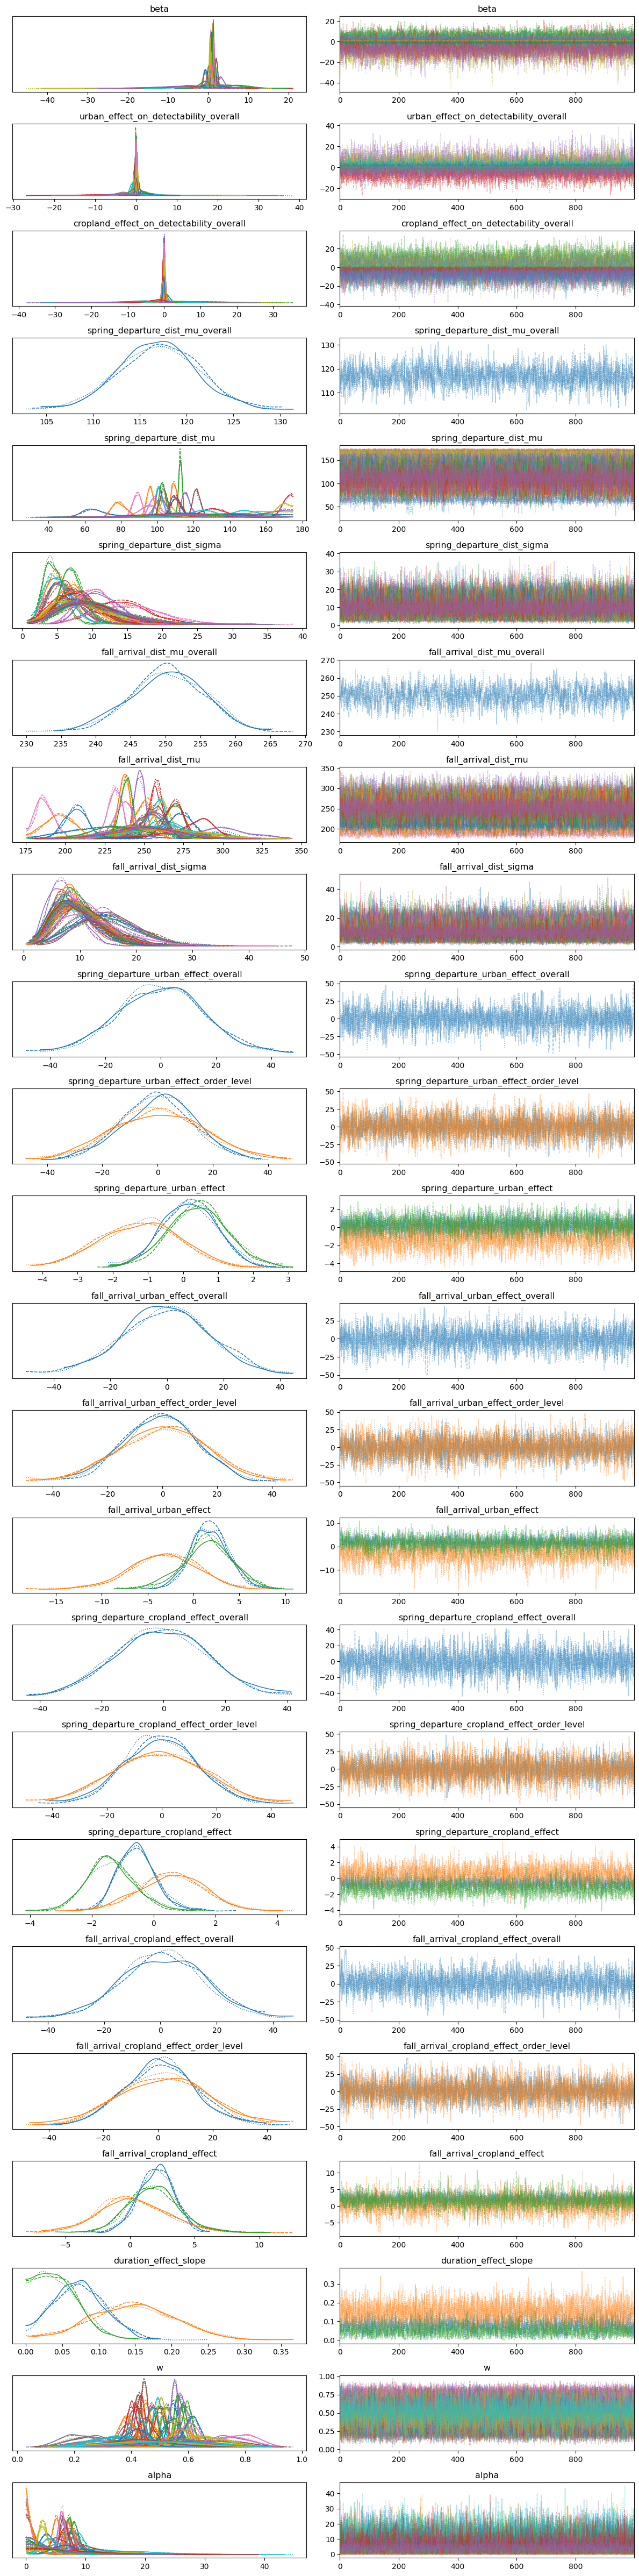

In [37]:
az.rcParams["plot.max_subplots"] = 50
az.plot_trace(idata)
plt.tight_layout()
plt.show()


In [38]:
###
ess_ = az.ess(idata)
rhat_ = az.rhat(idata)
bfmi_ = az.bfmi(idata)
    
### save data
with open(f'{wintering_prefix}.pkl','wb') as f:
    pickle.dump({'idata':idata,'post_data':post_idata, ### trace and posterior predictives
                 'ess':ess_,'rhat':rhat_,'bmfi':bfmi_, ### evaluations
                 'train_roc_auc':roc_auc_score(y_train, post_bi),
                 'train_precision':precision_score(y_train, post_bi), 
                 'train_recall':recall_score(y_train, post_bi), 
                 'train_f1':f1_score(y_train, post_bi),
                 
                 'test_roc_auc':roc_auc_score(y_test, y_pred),
                 'test_precision':precision_score(y_test, y_pred), 
                 'test_recall':recall_score(y_test, y_pred), 
                 'test_f1':f1_score(y_test, y_pred),
                 
                 'X_train_duration_minutes_std':X_train_duration_minutes_std,
                 'X_train_duration_minutes_mean':X_train_duration_minutes_mean,
                 'X_train_cropland_std':X_train_cropland_std,
                 'X_train_cropland_mean':X_train_cropland_mean,
                 'X_train_urban_areas_std':X_train_urban_areas_std,
                 'X_train_urban_areas_mean':X_train_urban_areas_mean
                 }, f)



In [39]:
rhat_

<xarray.Dataset>
Dimensions:                                       (sp_index: 3, year_index: 15,
                                                   order_index: 2, w_dim_0: 3,
                                                   w_dim_1: 15, w_dim_2: 2)
Coordinates:
  * sp_index                                      (sp_index) int64 0 1 2
  * year_index                                    (year_index) int64 0 1 ... 14
  * order_index                                   (order_index) int64 0 1
  * w_dim_0                                       (w_dim_0) int64 0 1 2
  * w_dim_1                                       (w_dim_1) int64 0 1 ... 13 14
  * w_dim_2                                       (w_dim_2) int64 0 1
Data variables: (12/24)
    beta                                          (sp_index, year_index) float64 ...
    urban_effect_on_detectability_overall         (sp_index, year_index) float64 ...
    cropland_effect_on_detectability_overall      (sp_index, year_index) float64 ...
    spring_departure_dist_mu_overall              float64 1.001
    spring_departure_dist_mu                      (sp_index, year_index) float64 ...
    spring_departure_dist_sigma                   (sp_index, year_index) float64 ...
    ...                                            ...
    fall_arrival_cropland_effect_overall          float64 1.002
    fall_arrival_cropland_effect_order_level      (order_index) float64 1.001...
    fall_arrival_cropland_effect                  (sp_index) float64 1.0 ... ...
    duration_effect_slope                         (sp_index) float64 1.002 .....
    w                                             (w_dim_0, w_dim_1, w_dim_2) float64 ...
    alpha                                         (sp_index, year_index) float64 ...

In [41]:
bfmi_

array([0.98957416, 0.84320372, 0.84481964])

# 6\. Fall departure model

## 6\.0 Train test split

In [49]:
from sklearn.model_selection import train_test_split
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for sp in breeding_df.sp.unique():
    sub = breeding_df[breeding_df.sp==sp]
    
    X_train, X_test, y_train, y_test = train_test_split(sub[[i for i in sub.columns if not i=='occ']],
                                                        sub['occ'],test_size=0.2)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    
X_train = pd.concat(X_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

#### normalize
X_train_duration_minutes_std= X_train.duration_minutes.std()
X_train_duration_minutes_mean= X_train.duration_minutes.mean()
X_train_cropland_std= X_train.cropland.std()
X_train_cropland_mean= X_train.cropland.mean()
X_train_urban_areas_std= X_train.urban_areas.std()
X_train_urban_areas_mean= X_train.urban_areas.mean()

X_train['duration_minutes'] = (X_train['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_test['duration_minutes'] = (X_test['duration_minutes'] - X_train_duration_minutes_mean)/X_train_duration_minutes_std
X_train['cropland'] = (X_train['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_test['cropland'] = (X_test['cropland'] - X_train_cropland_mean)/X_train_cropland_std
X_train['urban_areas'] = (X_train['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std
X_test['urban_areas'] = (X_test['urban_areas'] - X_train_urban_areas_mean)/X_train_urban_areas_std



## 6\.1 Define model

In [42]:
### passenger model
def cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
    return 0.5 + 0.5 * pm.math.erf((x-mu)/(sigma*s))

### running

breeding_model = pm.Model()

with breeding_model:
    breeding_model.add_coord("record_index", sorted(breeding_df['record_index'].unique()))
    breeding_model.add_coord("sp_index", sorted(breeding_df['sp_index'].unique()))
    breeding_model.add_coord("year_index", sorted(breeding_df['year_index'].unique()))
    breeding_model.add_coord("order_index", sorted(breeding_df['order_index'].unique()))
    
    
    DOY_obs = pm.Data('DOY_obs',X_train.DOY.values)
    occ_obs = pm.Data('occ_obs',y_train.values)
    urban_areas_obs = pm.Data('urban_areas_obs',X_train.urban_areas.values)
    cropland_obs = pm.Data('cropland_obs',X_train.cropland.values)
    duration_obs = pm.Data('duration_obs',X_train.duration_minutes.values)
    
    sp_index_obs = pm.Data('sp_index_obs', X_train.sp_index.values)
    year_index_obs = pm.Data('year_index_obs', X_train.year_index.values)
    order_to_sp_obs = pm.Data('order_to_sp_obs', X_train[['sp_index','order_index']].drop_duplicates().sort_values(by='sp_index')['order_index'].values)
    
    ### prior
    ## spring departure
    spring_arrival_dist_mu_overall = pm.TruncatedNormal('spring_arrival_dist_mu_overall', mu=106, sigma=20, lower=0, upper=175)
    spring_arrival_dist_mu = pm.TruncatedNormal('spring_arrival_dist_mu', mu=spring_arrival_dist_mu_overall, sigma=20, lower=0, upper=175, dims=('sp_index','year_index'))
    spring_arrival_dist_sigma = pm.Gamma('spring_arrival_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    ## fall arrival
    fall_departure_dist_mu_overall = pm.TruncatedNormal('fall_departure_dist_mu_overall', mu=291, sigma=20, lower=175, upper=366)
    fall_departure_dist_mu = pm.TruncatedNormal('fall_departure_dist_mu', mu=fall_departure_dist_mu_overall, sigma=20, lower=175, upper=366, dims=('sp_index','year_index'))
    fall_departure_dist_sigma = pm.Gamma('fall_departure_dist_sigma', alpha=5, beta=0.5, dims=('sp_index','year_index'))
    
    # #### urban effect   
    spring_arrival_urban_effect_overall = pm.TruncatedNormal('spring_arrival_urban_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    spring_arrival_urban_effect_order_level = pm.TruncatedNormal('spring_arrival_urban_effect_order_level', mu=spring_arrival_urban_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    spring_arrival_urban_effect = pm.TruncatedNormal('spring_arrival_urban_effect', mu=spring_arrival_urban_effect_order_level[order_to_sp_obs], 
                                              sigma=20, upper=50, lower=-50, dims=('sp_index'))
    fall_departure_urban_effect_overall = pm.TruncatedNormal('fall_departure_urban_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    fall_departure_urban_effect_order_level = pm.TruncatedNormal('fall_departure_urban_effect_order_level', mu=fall_departure_urban_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    fall_departure_urban_effect = pm.TruncatedNormal('fall_departure_urban_effect', mu=fall_departure_urban_effect_order_level[order_to_sp_obs],
                                          sigma=20, upper=50, lower=-50, dims=('sp_index'))
    
    #### cropland effect   
    spring_arrival_cropland_effect_overall = pm.TruncatedNormal('spring_arrival_cropland_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    spring_arrival_cropland_effect_order_level = pm.TruncatedNormal('spring_arrival_cropland_effect_order_level', mu=spring_arrival_cropland_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    spring_arrival_cropland_effect = pm.TruncatedNormal('spring_arrival_cropland_effect', mu=spring_arrival_cropland_effect_order_level[order_to_sp_obs], 
                                                 sigma=20, upper=50, lower=-50, dims=('sp_index'))
    fall_departure_cropland_effect_overall = pm.TruncatedNormal('fall_departure_cropland_effect_overall', mu=0, sigma=20, upper=50, lower=-50)
    fall_departure_cropland_effect_order_level = pm.TruncatedNormal('fall_departure_cropland_effect_order_level', mu=fall_departure_cropland_effect_overall, sigma=20, upper=50, lower=-50, dims=('order_index'))
    fall_departure_cropland_effect = pm.TruncatedNormal('fall_departure_cropland_effect', mu=fall_departure_cropland_effect_order_level[order_to_sp_obs], 
                                             sigma=20, upper=50, lower=-50, dims=('sp_index'))
    
    ##### intercept
    beta = pm.Normal('beta', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    ### duration effect
    duration_effect_slope = pm.TruncatedNormal('duration_effect_slope', mu=0, sigma=10, lower=0, dims=('sp_index'))
    
    #### city effect modification on timing
    #####
    
    modified_spring_arrival_dist = spring_arrival_dist_mu[sp_index_obs, year_index_obs] + \
                                        (spring_arrival_urban_effect[sp_index_obs] * urban_areas_obs + \
                                            spring_arrival_cropland_effect[sp_index_obs] * cropland_obs)
    modified_fall_departure_dist = fall_departure_dist_mu[sp_index_obs, year_index_obs] + \
                                        (fall_departure_urban_effect[sp_index_obs] * urban_areas_obs + \
                                            fall_departure_cropland_effect[sp_index_obs] * cropland_obs)

    ### scaling factor
    w = pm.Dirichlet('w', a=np.ones([len(X_train.sp_index.unique()),
                                    len(X_train.year_index.unique()),
                                    2]))
    soft_diff_constraint_on_w = pm.Potential("soft_diff_constraint_on_w", -((pm.math.log(w[...,0]) - pm.math.log(w[...,1]))**2))

    ### variables times scalers
    spring_arrival_effect_on_obs_prob = (cumulative_normal(x=DOY_obs, 
                              mu=modified_spring_arrival_dist, 
                              sigma=spring_arrival_dist_sigma[sp_index_obs, year_index_obs])) * w[sp_index_obs, year_index_obs, 0]
 
        
    fall_departure_effect_on_obs_prob =  -(cumulative_normal(x=DOY_obs, 
                                                         mu=modified_fall_departure_dist, 
                                                         sigma=fall_departure_dist_sigma[sp_index_obs, year_index_obs]))* w[sp_index_obs, year_index_obs, 1]

    #### Effect of land use on detectability
    urban_effect_on_detectability_overall = pm.Normal('urban_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    cropland_effect_on_detectability_overall = pm.Normal('cropland_effect_on_detectability_overall', mu=0, sigma=10, dims=('sp_index','year_index'))
    
    #### alpha
    alpha = pm.HalfNormal('alpha', sigma=10, dims=('sp_index','year_index'))
    
    #### linear term 
    y0 = beta[sp_index_obs, year_index_obs] + \
            duration_effect_slope[sp_index_obs] * duration_obs + \
            urban_effect_on_detectability_overall[sp_index_obs, year_index_obs] * urban_areas_obs + \
            cropland_effect_on_detectability_overall[sp_index_obs, year_index_obs] * cropland_obs + \
            alpha[sp_index_obs, year_index_obs] * (spring_arrival_effect_on_obs_prob + fall_departure_effect_on_obs_prob)
            
    p_ = pm.math.sigmoid(y0)
    
    y_ = pm.Bernoulli("y_", p_, observed=occ_obs)
    

    

    

## 6\.2 Sample chains

In [51]:
import pymc.sampling.jax as pmjax
import jax
import tensorflow_probability.substrates.jax as tfp
jax.scipy.special.erfcx = tfp.math.erfcx
from fastprogress.fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import force_console_behavior
master_bar, progress_bar = force_console_behavior()

with breeding_model:
    idata = pmjax.sample_numpyro_nuts(SAMPLE_SIZE,chains=SAMPLE_CHAINS,cores=SAMPLE_CORES, tune=TUNES, progressbar=True)
    
    #  target_accept=0.99,
    #                   chains=2, cores=2, tune=3000, progressbar=True,
    #                     # trace = ['y_']
                      

Compiling...
Compilation time =  0:00:18.229348
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
with breeding_model:
    post_idata = pm.sample_posterior_predictive(idata)

<Axes: xlabel='DOY'>

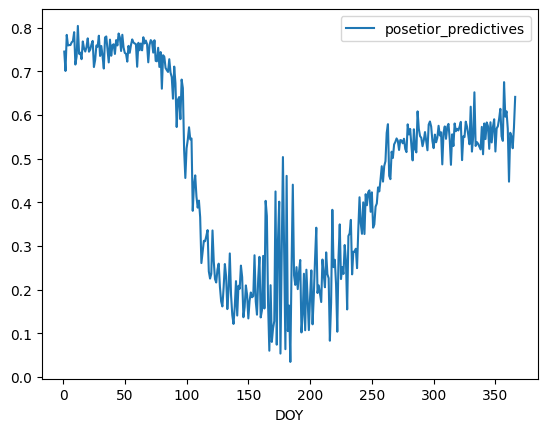

In [ ]:
pd.DataFrame({
    'DOY':X_train.DOY.values,
    'posetior_predictives':np.concatenate(post_idata.posterior_predictive['y_'], axis=0).mean(axis=0)
}).groupby('DOY').mean().plot()


## 6\.3 Predict on test data

In [ ]:
def pm_predict_breeding_model(X_test):
    ### passenger model
    import math
    from scipy.special import expit
    def math_cumulative_normal(x, mu, sigma, s=np.sqrt(2)):
        return 0.5 + 0.5 * math.erf((x-mu)/(sigma*s))

    new_DOY_obs = X_test['DOY'].values
    new_sp_index_obs = X_test['sp_index'].values
    new_year_index_obs = X_test['year_index'].values
    new_urban_areas_obs = X_test['urban_areas'].values
    new_cropland_obs = X_test['cropland'].values
    new_duration_obs = X_test['duration_minutes'].values

    new_beta = np.concatenate(idata.posterior['beta'].values, axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_duration_effect_on_obs_prob = np.concatenate(idata.posterior['duration_effect_slope'].values, axis=0).mean(axis=0)[new_sp_index_obs]

    new_modified_spring_arrival_dist = np.concatenate(idata.posterior['spring_arrival_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                            np.concatenate(idata.posterior['spring_arrival_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                                np.concatenate(idata.posterior['spring_arrival_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                                
    new_spring_arrival_effect_on_obs_prob =  (
        np.array([math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
        new_DOY_obs,
        new_modified_spring_arrival_dist, 
        np.concatenate(idata.posterior['spring_arrival_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    )])) * np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 0]

    new_modified_fall_departure_dist = np.concatenate(idata.posterior['fall_departure_dist_mu'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs] + \
                                        np.concatenate(idata.posterior['fall_departure_urban_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_urban_areas_obs + \
                                            np.concatenate(idata.posterior['fall_departure_cropland_effect'], axis=0).mean(axis=0)[new_sp_index_obs] * new_cropland_obs
                                            
    new_fall_departure_effect_on_obs_prob = (np.array([
        -math_cumulative_normal(x=x,mu=mu,sigma=sigma) for x,mu,sigma in zip(
            new_DOY_obs,
            new_modified_fall_departure_dist,
            np.concatenate(idata.posterior['fall_departure_dist_sigma'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
        )
    ]))* np.concatenate(idata.posterior['w'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs, 1]

    new_alpha = np.concatenate(idata.posterior['alpha'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_urban_effect_on_detectability_overall = np.concatenate(idata.posterior['urban_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    new_cropland_effect_on_detectability_overall = np.concatenate(idata.posterior['cropland_effect_on_detectability_overall'], axis=0).mean(axis=0)[new_sp_index_obs, new_year_index_obs]
    
    new_y0 = new_beta + \
            new_duration_effect_on_obs_prob * new_duration_obs + \
            new_urban_effect_on_detectability_overall * new_urban_areas_obs + \
            new_cropland_effect_on_detectability_overall * new_cropland_obs + \
            new_alpha * (new_spring_arrival_effect_on_obs_prob + new_fall_departure_effect_on_obs_prob)
            
    new_p_ = expit(new_y0)
    y_pred = np.where(new_p_>0.5,1,0)
    return y_pred





In [ ]:
y_pred = pm_predict_breeding_model(X_test)

In [ ]:
post_bi = np.where(
    np.concatenate(post_idata.posterior_predictive['y_'].values, axis=0).mean(axis=0)>0.5,
    1,0
)


In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

print(
    roc_auc_score(y_train, post_bi), precision_score(y_train, post_bi), recall_score(y_train, post_bi), f1_score(y_train, post_bi)
)

print(
    roc_auc_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)
)


0.7506726047077877 0.7062264150943396 0.855934141321747 0.773906750749509
0.7326820049369971 0.6945481702763256 0.8416289592760181 0.7610474631751227


## 6\.4 Evaluate and save data

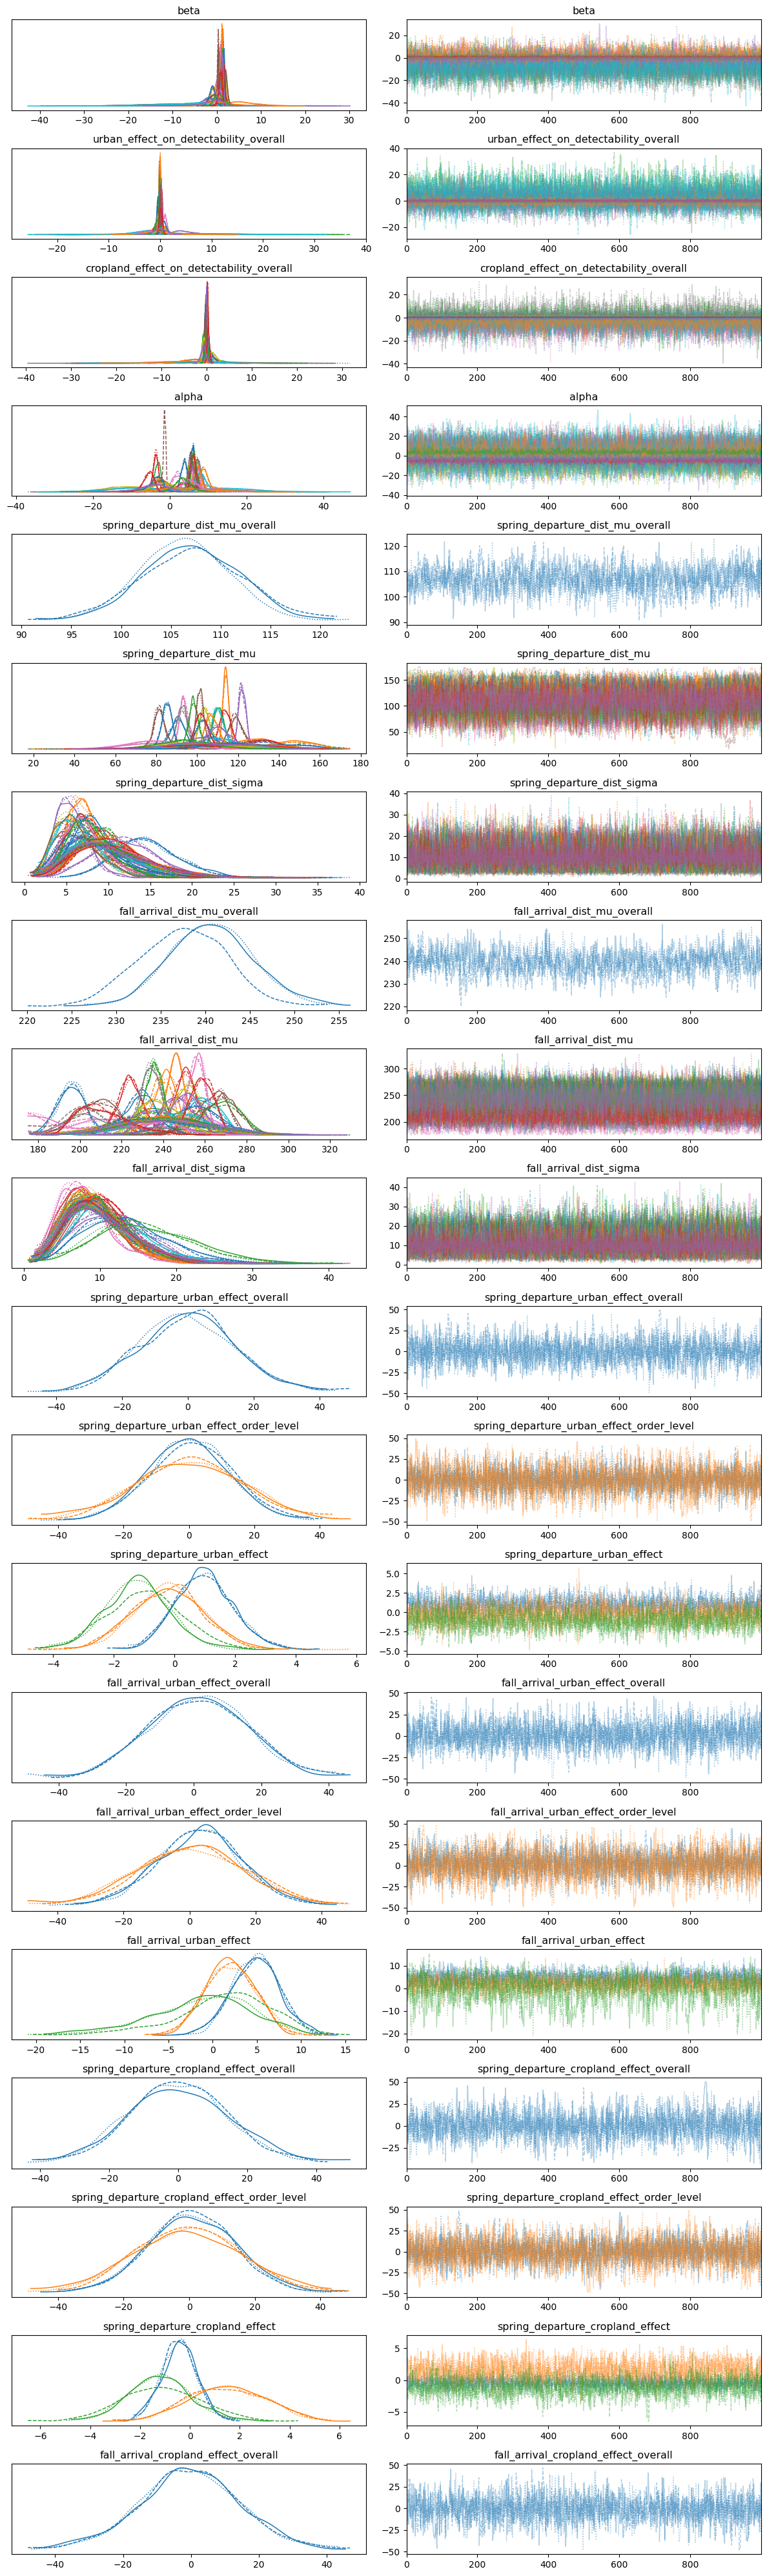

In [ ]:
az.rcParams["plot.max_subplots"] = 50
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [ ]:
###
ess_ = az.ess(idata)
rhat_ = az.rhat(idata)
bfmi_ = az.bfmi(idata)
    
### save data
with open(f'{breeding_prefix}.pkl','wb') as f:
    pickle.dump({'idata':idata,'post_data':post_idata, ### trace and posterior predictives
                 'ess':ess_,'rhat':rhat_,'bmfi':bfmi_, ### evaluations
                 'train_roc_auc':roc_auc_score(y_train, post_bi),
                 'train_precision':precision_score(y_train, post_bi), 
                 'train_recall':recall_score(y_train, post_bi), 
                 'train_f1':f1_score(y_train, post_bi),
                 
                 'test_roc_auc':roc_auc_score(y_test, y_pred),
                 'test_precision':precision_score(y_test, y_pred), 
                 'test_recall':recall_score(y_test, y_pred), 
                 'test_f1':f1_score(y_test, y_pred),
                 
                 'X_train_duration_minutes_std':X_train_duration_minutes_std,
                 'X_train_duration_minutes_mean':X_train_duration_minutes_mean,
                 'X_train_cropland_std':X_train_cropland_std,
                 'X_train_cropland_mean':X_train_cropland_mean,
                 'X_train_urban_areas_std':X_train_urban_areas_std,
                 'X_train_urban_areas_mean':X_train_urban_areas_mean
                 }, f)



In [ ]:
rhat_

<xarray.Dataset>
Dimensions:                                       (sp_index: 3, year_index: 15,
                                                   order_index: 2, w_dim_0: 3,
                                                   w_dim_1: 15, w_dim_2: 2)
Coordinates:
  * sp_index                                      (sp_index) int64 0 1 2
  * year_index                                    (year_index) int64 0 1 ... 14
  * order_index                                   (order_index) int64 0 1
  * w_dim_0                                       (w_dim_0) int64 0 1 2
  * w_dim_1                                       (w_dim_1) int64 0 1 ... 13 14
  * w_dim_2                                       (w_dim_2) int64 0 1
Data variables: (12/24)
    beta                                          (sp_index, year_index) float64 ...
    urban_effect_on_detectability_overall         (sp_index, year_index) float64 ...
    cropland_effect_on_detectability_overall      (sp_index, year_index) float64 ...
    alpha                                         (sp_index, year_index) float64 ...
    spring_departure_dist_mu_overall              float64 1.023
    spring_departure_dist_mu                      (sp_index, year_index) float64 ...
    ...                                            ...
    spring_departure_cropland_effect              (sp_index) float64 1.002 .....
    fall_arrival_cropland_effect_overall          float64 1.0
    fall_arrival_cropland_effect_order_level      (order_index) float64 1.001...
    fall_arrival_cropland_effect                  (sp_index) float64 1.001 .....
    duration_effect_slope                         (sp_index) float64 1.002 .....
    w                                             (w_dim_0, w_dim_1, w_dim_2) float64 ...

In [ ]:
bfmi_

array([0.82503237, 0.9409618 , 0.88500357])